In [194]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [195]:
# cd '/content/drive/MyDrive/딥러닝 과제/Pokemon/Fake'

In [196]:
cd '/content/drive/MyDrive/4조/머신러닝과제/딥러닝과제/Pokemon'

/content/drive/MyDrive/4조/머신러닝과제/딥러닝과제/Pokemon


In [197]:
# cd '/content/drive/MyDrive/딥러닝 과제/Pokemon'

In [198]:
!ls

acc_basic_loss_plot.png  loss_plot.png	       splitted
baseline.pt		 Pokemon.ipynb	       VGG16_Acc_plot.png
GoogLeNet_loss_plot.png  SET_UP_Pokemon.ipynb


In [199]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import random
import cv2
import glob
from PIL import Image
import PIL.ImageOps
import torch
import os
import torch.backends.cudnn as cudnn
import pandas as pd

## Train, Validation Dataset

In [200]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
BATCH_SIZE = 50
EPOCH = 300

In [201]:
## random number
# 출처 : https://jsc5565.tistory.com/21
# 출처 : https://hoya012.github.io/blog/reproducible_pytorch/
# 출처(Data Loader) : https://discuss.pytorch.org/t/shuffle-issue-in-dataloader-how-to-get-the-same-data-shuffle-results-with-fixed-seed-but-different-network/45357/9
# 출처 : https://velog.io/@jhlee508/Code-Reproduction%EC%9D%84-%EC%9C%84%ED%95%9C-Seed-%EA%B3%A0%EC%A0%95-feat.-OS-Numpy-Random-PyTorch-Tensorflow
# pytorch random seed
random_seed = 2022
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)
os.environ["PYTHONHASHSEED"] = str(random_seed)

In [202]:
# 참고 : https://deep-learning-study.tistory.com/521
# from torchvision.transforms.transforms import FiveCrop. 사용하 않음
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder 

transform_base = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()])

train_dataset = ImageFolder(root='./splitted/train', transform=transform_base) 
val_dataset = ImageFolder(root='./splitted/val', transform=transform_base)

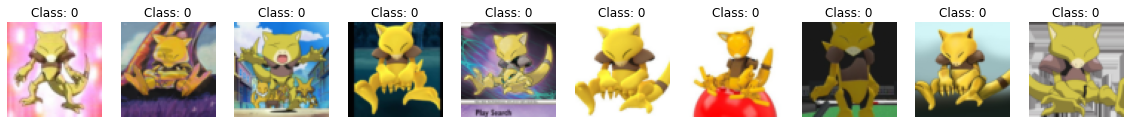

In [203]:
# imshow 참고 : https://ndb796.tistory.com/372, np.transpose(image,(1, 2, 0))의미
pltsize = 2
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
  plt.subplot(1, 10, i + 1)
  plt.axis('off')
  image, label = train_dataset[i]
  plt.imshow(np.transpose(image,(1, 2, 0)))
  plt.title('Class: ' + str(label))

In [204]:
def set_seed(seed):
  torch.manual_seed(random_seed)
  torch.cuda.manual_seed(random_seed)
  torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(random_seed)
  random.seed(random_seed)
  os.environ["PYTHONHASHSEED"] = str(random_seed)

In [205]:
set_seed(2022)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last = True, worker_init_fn=np.random.seed(2022))
set_seed(2022)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last = True, worker_init_fn=np.random.seed(2022))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [206]:
first_batch = train_loader.__iter__().__next__()
print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('Num of Total', '', len(train_dataset)))
print('{:15s} | {:<25s} | {}'.format('Num of Batch', '', len(train_loader)))
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)), len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first_batch[1]', str(type(first_batch[1])), first_batch[1].shape))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


name            | type                      | size
Num of Total    |                           | 7002
Num of Batch    |                           | 140
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 3, 64, 64])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


In [207]:
# 데이터 확인하기
set_seed(2022)
for (X_train, y_train) in train_loader:
 print('X_train:', X_train.size( ), 'type:', X_train.type( ))
 print('y_train:', y_train.size( ), 'type:', y_train.type( ))
 break
# X _train: torch.Size([5, 3, 64, 64]) type: torch.FloatTensor
# y _train: torch.Size([5]) type: torch.LongTensor

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


X_train: torch.Size([50, 3, 64, 64]) type: torch.FloatTensor
y_train: torch.Size([50]) type: torch.LongTensor


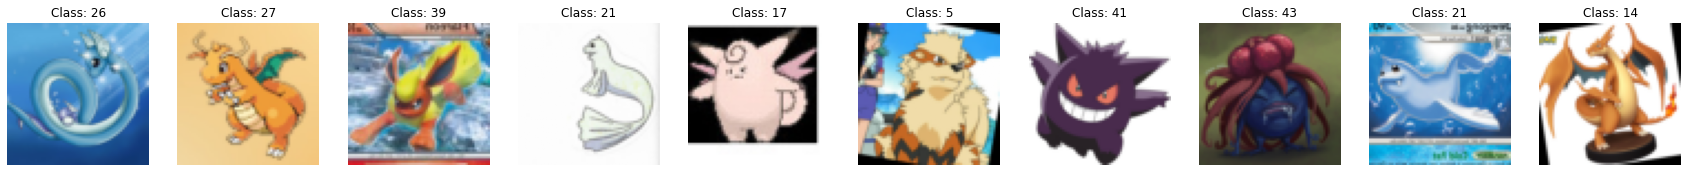

In [208]:
pltsize = 3
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
 plt.subplot(1, 10, i + 1)
 plt.axis('off')
 plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
 plt.title('Class: ' + str(y_train[i].item( )))

## 클래스의 수 (종속변수)

In [209]:
!ls

acc_basic_loss_plot.png  loss_plot.png	       splitted
baseline.pt		 Pokemon.ipynb	       VGG16_Acc_plot.png
GoogLeNet_loss_plot.png  SET_UP_Pokemon.ipynb


In [210]:
directory = "./splitted/train"
labels = os.listdir(directory)
class_num = len(labels)
print(labels)

['Abra', 'Aerodactyl', 'Arcanine', 'Alakazam', 'Arbok', 'Articuno', 'Alolan Sandslash', 'Golduck', 'Gastly', 'Geodude', 'Grimer', 'Goldeen', 'Golbat', 'Graveler', 'Gyarados', 'Gloom', 'Golem', 'Growlithe', 'Gengar', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon']


In [211]:
class_num

52

## 베이스라인 모델 설계

### 베이스라인 모델 설계

In [212]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 
class Net(nn.Module): 
  
    def __init__(self): 
    
        super(Net, self).__init__() 

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) 
        self.pool = nn.MaxPool2d(2,2)  
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)  

        # Linear에 해당하는 size를 구해보자.
        self.fc1 = nn.Linear(4096, 512) 
        # 마지막에는 클래스 수량을 입력해야함
        self.fc2 = nn.Linear(512, class_num) 
    
    
    # 최초 이미지 사이즈 : (3, 64, 64)
    def forward(self, x):  
    
        x = self.conv1(x)     # (32, 64, 64) 
        x = F.relu(x)  
        x = self.pool(x)      # (32, 32, 32)
        x = F.dropout(x, p=0.25, training=self.training) 

        x = self.conv2(x)     # (64, 32, 32)
        x = F.relu(x) 
        x = self.pool(x)      #  (64, 16, 16)
        x = F.dropout(x, p=0.25, training=self.training)

        x = self.conv3(x)     #  (64, 16, 16)
        x = F.relu(x) 
        x = self.pool(x)      #   (64, 8, 8)
        x = F.dropout(x, p=0.25, training=self.training)

        x = x.view(-1, 4096)  # 64*8*8 = 4096
        x = self.fc1(x)       # (512)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)       # 

        return F.log_softmax(x, dim=1)  


model = Net().to(DEVICE)  
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [213]:
from torchsummary import summary

# print model summary
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
         MaxPool2d-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,928
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Linear-7                  [-1, 512]       2,097,664
            Linear-8                   [-1, 52]          26,676
Total params: 2,180,660
Trainable params: 2,180,660
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 2.04
Params size (MB): 8.32
Estimated Total Size (MB): 10.40
----------------------------------------------------------------


In [214]:
print(model)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=52, bias=True)
)


## 베이스라인 모델 설계

### 모델 학습을 위한 함수

In [215]:
def train(model, train_loader, optimizer):
  # set_seed(2022)
  model.train()
  train_correct = 0
  # 모델이 학습되는 동안 trainning loss를 track
  train_losses = []
  # 모델이 학습되는 동안 trainning accracy를 track
  train_acces = []

  set_seed(2022)
  for batch, (data, target) in enumerate(train_loader, 1):
    data, target = data.to(DEVICE), target.to(DEVICE)
    # clear the gradients of all optimized variables
    optimizer.zero_grad()    
    # forward pass: 입력된 값을 모델로 전달하여 예측 출력 계산
    output = model(data)
    # calculate the loss
    loss = F.cross_entropy(output, target)
    # backward pass: 모델의 파라미터와 관련된 loss의 그래디언트 계산
    loss.backward()
    # perform a single optimization step (parameter update)
    optimizer.step()

### 모델 평가를 위한 함수

In [216]:
def evaluate(model, test_loader):
  model.eval() # prep model for evaluation
  val_correct = 0
  loss = 0
  # 모델이 학습되는 동안 validation loss를 track
  valid_losses = []
  # 모델이 학습되는 동안 vaildation accuracy를 track
  # val_acces = []

  ## Gradient를 통해 파라미터 값이 업데이트되는 현상을 방지하기 위해
  ## torch.no_grad()메서드를 이용해 Gradient의 흐름을 억제합니다.
  with torch.no_grad():
    set_seed(2022)
    for data , target in  test_loader:
      # forward pass: 입력된 값을 모델로 전달하여 예측 출력 계산
      data, target = data.to(DEVICE), target.to(DEVICE)
      output = model(data)
      # calculate the loss
      loss = F.cross_entropy(output, target)
      # record validation loss
      valid_losses.append(loss.item())
      pred = output.max(1, keepdim=True)[1]
      val_correct += pred.eq(target.view_as(pred)).sum().item()
  val_accuracy = 100. * val_correct / (len(test_loader) * BATCH_SIZE)
  # print(val_correct, (len(test_loader) * BATCH_SIZE))
  # val_acces.append(val_accuracy)
  
  return valid_losses, val_accuracy

### Early Stopping

In [217]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0.1, path='checkpoint.pt', val_accuracy_min = 0):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = val_accuracy_min
        self.early_stop = False
        self.val_accuracy_min = val_accuracy_min
        self.delta = delta
        self.path = path

    def __call__(self, val_accracy, model):

        score = val_accracy

        if self.best_score == 0:
            self.best_score = score
            self.save_checkpoint(val_accracy, model)
            
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_accracy, model)
            self.counter = 0

    def save_checkpoint(self, val_accracy, model):
        '''validation accuracy가 증가하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation increased ({self.val_accuracy_min:.6f} --> {val_accracy:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_accuracy_min = val_accracy

### Early Stopping 모델 정의

In [218]:
import time

In [219]:
def train_model(model, batch_size, patience, n_epochs):

    # 모델이 학습되는 동안 trainning loss를 track
    # train_losses = []
    # 모델이 학습되는 동안 validation loss를 track
    # valid_losses = []
    # 모델이 학습되는 동안 trainning accracy를 track
    # train_acces = []
    # 모델이 학습되는 동안 vaildation accuracy를 track
    # val_acces = []
    # epoch당 average training loss를 track
    avg_train_losses = []
    # epoch당 average validation loss를 track
    avg_valid_losses = []
    # epoch당 average training accuracy를 track


    #####################################
    ### pkl 파일 확인하여 중간 값을 넣어야 함 ###
    #####################################
    since = time.time()

    avg_train_accuracies = []
    avg_valid_accuracies = []

    dir = '/content/drive/MyDrive/딥러닝 과제/Pokemon'
    files = os.listdir(dir)

    for file in files:
      if file == 'acc_basic.pkl':
        print("catch acc_basic.pkl")
        acc_df = pd.read_pickle(dir + '/' + file)
        avg_train_accuracies = acc_df.train_accuracy.to_list()
        avg_valid_accuracies = acc_df.val_accuracy.to_list()

    if len(avg_valid_accuracies) == 0:
      val_accracy_check = 0
    else:
      val_accracy_check = max(avg_valid_accuracies)


    # early_stopping object의 초기화
    print('Minimum val accuracy : {:.6f}\n'.format(val_accracy_check))
    early_stopping = EarlyStopping(patience = patience, verbose = True,
                                   path = '/content/drive/MyDrive/딥러닝 과제/Pokemon/acc_basic.pt',
                                   val_accuracy_min = val_accracy_check)

    for epoch in range(1, n_epochs + 1):


        ###################
        # train the model #
        ###################
        train(model, train_loader, optimizer)

        train_losses, train_acces = evaluate(model, train_loader)


        ######################    
        # validate the model #
        ######################
        valid_losses, val_acces = evaluate(model, val_loader)

        # print 학습/검증 statistics
        # epoch당 평균 loss 계산
        # loss 평균
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        # accuracy 평균
        train_accuracy = np.average(train_acces)
        val_accuracy = np.average(val_acces)
        # epoch에 대한 loss의 집합
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        # epoch에 대한 accuracy의 집합
        avg_train_accuracies.append(train_accuracy)
        avg_valid_accuracies.append(val_accuracy)


        epoch_len = len(str(n_epochs))


        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                    f'train_loss: {train_loss:.5f} ' +
                    f'train_accuracy: {train_accuracy:.5f} ' +
                    f'valid_loss: {valid_loss:.5f} '  + 
                    f'valid_accuracy: {val_accuracy:.5f}')
        
        print(print_msg)

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        train_acces = []
        val_acces = []

        # early_stopping는 validation loss가 감소하였는지 확인이 필요하며,
        # 만약 감소하였을경우 현제 모델을 checkpoint로 만든다.
        early_stopping(val_accuracy, model)

        time_elapsed = time.time() - since

        if time_elapsed // 60 < 1:
          time.sleep(15)

        acc_df = pd.DataFrame({"train_accuracy" : avg_train_accuracies,
                       "val_accuracy" : avg_valid_accuracies})
        
        

        acc_df.to_pickle('/content/drive/MyDrive/딥러닝 과제/Pokemon/acc_basic.pkl')

        print("DataFrame 저장 완료!")

        if early_stopping.early_stop:
            print("Early stopping")
            break

    # best model이 저장되어있는 last checkpoint를 로드한다.
    model.load_state_dict(torch.load('/content/drive/MyDrive/딥러닝 과제/Pokemon/acc_basic.pt'))

    print("Model 로드 완료!")

    return  model, avg_train_accuracies, avg_valid_accuracies

## 모델 불러오기

In [220]:
### 이전 저장된 pt 파일이 있으면 pt 파일을 불러온다. ###
dir = '/content/drive/MyDrive/딥러닝 과제/Pokemon'
files = os.listdir(dir)

for file in files:
  if file == 'acc_basic.pt':
    print("catch acc_basic.pt")
    if USE_CUDA == 1:
      model.load_state_dict(torch.load(dir + '/' + file))
      print(model.load_state_dict(torch.load(dir + '/' + file)))

    else:
      model.load_state_dict(torch.load(dir + '/' + file, map_location=torch.device('cpu')))
      print(model.load_state_dict(torch.load(dir + '/' + file, map_location=torch.device('cpu'))))     

catch acc_basic.pt
<All keys matched successfully>


## 모델 학습 (이어서)

In [221]:
# early stopping patience;
# validation loss가 개선된 마지막 시간 이후로 얼마나 기다릴지 지정
patience = 60
model, train_acc, valid_acc = train_model(model, BATCH_SIZE, patience, EPOCH)

catch acc_basic.pkl
Minimum val accuracy : 34.500000



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[  1/300] train_loss: 1.58795 train_accuracy: 73.57143 valid_loss: 7.18626 valid_accuracy: 31.50000
EarlyStopping counter: 1 out of 60
DataFrame 저장 완료!


KeyboardInterrupt: ignored

## Eearly Stopping 체크포인트

In [ ]:
### 이전 저장된 pt 파일이 있으면 pt 파일을 불러온다. ###
dir = '/content/drive/MyDrive/딥러닝 과제/Pokemon'
files = os.listdir(dir)

for file in files:
  if file == 'acc_basic.pt':
    print("catch acc_basic.pt")
    if USE_CUDA == 1:
      model.load_state_dict(torch.load(dir + '/' + file))
      print(model.load_state_dict(torch.load(dir + '/' + file)))

    else:
      model.load_state_dict(torch.load(dir + '/' + file, map_location=torch.device('cpu')))
      print(model.load_state_dict(torch.load(dir + '/' + file, map_location=torch.device('cpu'))))     


acc_df = pd.read_pickle('/content/drive/MyDrive/딥러닝 과제/Pokemon/acc_basic.pkl')
train_acc = acc_df.train_accuracy.to_list()
valid_acc = acc_df.val_accuracy.to_list()

In [ ]:
# 훈련이 진행되는 과정에 따라 loss를 시각화
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_acc)+1),train_acc, label='train_acc')
plt.plot(range(1,len(valid_acc)+1),valid_acc,label='valid_acc')

# validation loss의 최저값 지점을 찾기
maxposs = valid_acc.index(max(valid_acc))+1
plt.axvline(maxposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('Accuracy(%)')
plt.ylim(0, 100) # 일정한 scale
plt.xlim(0, len(train_acc)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('acc_basic_loss_plot.png', bbox_inches = 'tight')

## 모델 평가

### 베이스라인 모델 평가를 위한 전처리

In [ ]:
set_seed(2022)
test_dataset = ImageFolder(root='./splitted/test',transform=transform_base)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last = True, worker_init_fn=np.random.seed(2022))

### 베이스라인 모델 성능 평가하기

In [ ]:
# test loss 및 accuracy을 모니터링하기 위해 list 초기화
test_loss = 0.0
class_correct = list(0. for i in range(class_num))
class_total = list(0. for i in range(class_num))


model.eval() # prep model for evaluation

# Gradient 업데이트를 하지 않음

set_seed(2022)
with torch.no_grad():
  for data, target in test_loader :
      data, target = data.to(DEVICE), target.to(DEVICE)

      if len(target.data) != BATCH_SIZE:
          break

      # forward pass: 입력을 모델로 전달하여 예측된 출력 계산
      output = model(data)
      # calculate the loss
      test_loss += F.cross_entropy(output, 
                    target, reduction='sum').item() 
      # 출력된 확률을 예측된 클래스로 변환
      # _, pred = torch.max(output, 1)
      pred = output.max(1, keepdim=True)[1]
      # 예측과 실제 라벨과 비교
      
      correct = np.squeeze(pred.eq(target.data.view_as(pred)))

      # 각 object class에 대해 test accuracy 계산
      for i in range(BATCH_SIZE):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] +=1

# calculate and print avg test loss
test_loss = test_loss/(len(test_loader) * BATCH_SIZE)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(class_num):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %.4f%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

## Visualize Sample Test Results

In [ ]:
# obtain one batch of test images
for i in range(2):
  dataiter = iter(test_loader)
  images, labels = dataiter.next()
  images, labels = images.to(DEVICE), labels.to(DEVICE)
  # get sample outputs
  output = model(images)
  # convert output probabilities to predicted class
  _, preds = torch.max(output, 1)
  # prep images for display
  images = images.cpu().numpy()
  labels = labels.cpu().numpy()
  # plot the images in the batch, along with predicted and true labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(10):
      ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
      ax.imshow(np.transpose(images[idx], (1, 2, 0)))
      ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                  color=("green" if preds[idx]==labels[idx] else "red"))